<a href="https://colab.research.google.com/github/Jantonyelly/facerecognition/blob/main/contin4-94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
data = pd.read_csv(r'/content/zeta_sol_IEEE68AC--conti4.csv')
data.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439
0,-0.654767,-0.700667,-0.648094,-0.785926,-0.765472,-0.744509,-0.743870,-0.660407,-0.326413,-0.440122,-0.363301,-0.823662,-0.858138,0.542747,0.294155,0,-0.975084,-0.104050,-0.831740,-0.851927,-0.858042,-0.810257,-0.822169,-0.877014,-0.720492,-0.714268,-0.789899,-0.567929,-0.493200,-0.685745,-0.617162,-0.543370,-0.635749,-0.772084,-0.771810,-0.872363,-0.837815,-0.617261,-0.974259,-0.343236,...,0.009397,0.418476,-8.065883,7.398504,4.254639,6.864996,0.139002,0.075539,0.139005,0.035050,2.592105,2.957386,0.429199,2.716974,4.796688,1.972747,7.689734,-11.117909,0.425741,-2.020049,-1.233729,-5.503058,-0.215765,1.400113,2.791107,-2.436116,-1.387701,-0.061192,0.686391,2.037245,-2.129039,0.091794,-3.205714,-0.001006,0.377888,-3.197011,-2.803898,0.474972,-0.362934,0
1,-1.056926,-1.036600,-1.042843,-1.140621,-1.084272,-1.147664,-1.130044,-1.058712,-0.721367,-1.016123,-1.005416,-1.115213,-1.151219,0.023641,-0.271096,0,-1.274404,-0.145641,-1.187639,-1.191768,-1.246038,-1.204081,-1.213255,-1.259231,-1.117432,-1.106434,-1.179655,-0.962362,-0.888034,-1.116036,-1.079656,-1.065301,-1.093645,-1.133002,-1.115978,-1.194041,-1.222196,-1.061605,-1.282667,-0.808892,...,1.180861,0.685916,-7.792667,7.130660,4.408717,-2.076072,-0.050293,0.177691,-0.050242,2.608912,2.507077,2.821057,1.884704,2.547792,4.623510,3.443271,10.023562,-13.428598,0.305728,-1.891419,-0.368189,-4.853915,0.213406,1.941012,3.333238,-2.525194,-1.388292,-0.190286,0.569476,1.277127,-1.397630,0.120503,-3.153384,-0.029371,0.315159,-3.173158,-2.841741,0.390646,-0.228706,0
2,-0.485537,-0.424480,-0.425817,-0.487376,-0.439520,-0.481349,-0.429234,-0.435048,-0.071290,-0.279703,-0.381687,-0.422708,-0.519149,0.740181,0.445686,0,-0.643710,-0.084083,-0.534018,-0.538838,-0.581771,-0.533683,-0.536066,-0.599391,-0.495322,-0.465277,-0.534419,-0.313015,-0.237961,-0.472173,-0.426442,-0.440561,-0.474593,-0.524777,-0.530859,-0.546847,-0.574900,-0.440991,-0.697223,-0.148464,...,-0.982337,0.784885,-7.716205,7.091125,4.686792,8.598895,-1.096271,0.537843,-1.096039,-0.973860,2.009661,1.997118,-0.197204,2.662941,4.639289,1.243003,5.027094,-8.239500,-0.460580,-1.044383,-1.113178,-3.782257,0.336880,1.736286,2.892578,-2.224347,-1.153413,0.026642,0.875343,1.221359,-1.323085,0.101727,-2.680313,-0.014943,0.510444,-2.688377,-2.168758,0.889214,-0.225851,0
3,-0.399518,-0.338218,-0.402695,-0.397027,-0.418572,-0.385424,-0.333250,-0.382728,-0.028025,-0.250656,-0.153927,-0.505058,-0.766558,0.424546,-0.031722,0,-0.858034,-0.108983,-0.465640,-0.492057,-0.504717,-0.446986,-0.449269,-0.529199,-0.440422,-0.413758,-0.479668,-0.268133,-0.194119,-0.468489,-0.411294,-0.336216,-0.435582,-0.586300,-0.600456,-0.670895,-0.513701,-0.423320,-0.857174,-0.211930,...,-0.843710,0.317660,-7.472901,6.817137,7.791368,1.148140,0.180354,0.099909,0.180431,-2.031322,2.580386,2.911129,-0.525396,2.364930,4.373453,0.943853,5.483634,-8.860805,-0.788189,-0.803958,0.072928,-4.090737,-0.135732,1.256883,3.512858,-3.243966,-2.248838,-0.942617,-1.099686,1.022373,-1.113295,0.090922,-2.134252,0.001636,0.592155,-2.128106,-1.531456,1.588661,-0.088552,0
4,-1.061267,-1.046116,-1.047895,-1.141464,-1.192787,-1.084721,-1.051286,-1.025664,-0.756708,-0.943720,-0.945527,-1.068194,-1.096007,0.119455,-0.213303,0,-1.231503,-0.139121,-1.202508,-1.248480,-1.203851,-1.148534,-1.154135,-1.228340,-1.099459,-1.101248,-1.166312,-0.978207,-0.910424,-1.071231,-1.028918,-1.012837,-1.044214,-1.087774,-1.071669,-1.149699,-1.202623,-1.012038,-1.244124,-0.746113,...,1.074993,0.681350,-7.845428,7.195527,5.108164,-1.294968,-0.149826,0.195747,-0.149806,2.372483,2.449237,2.737049,1.771080,2.641403,4.698569,3.269422,9.644247,-12.960254,0.166588,-1.734091,-1.029622,-4.754052,0.153771,1.797731,2.852095,-2.146795,-1.051663,0.1

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import timeit
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.utils import class_weight

In [4]:
 #TensorFlow 2 -> Keras
from tensorflow import keras

In [5]:
try:
    # Using experimental HalvingRandomSearchCV for hyperparameters optimization
    from sklearn.experimental import enable_halving_search_cv # noqa
    from sklearn.model_selection import HalvingRandomSearchCV
except ImportError:
    print('HalvingRandomSearchCV not found. Update scikit-learn to 0.24.')

In [6]:
pip install scikit-learn==0.24.2

In [7]:
#rom bayes_optim.bayesian_optimization import BayesianOptimization
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
# Inline figures
%matplotlib inline

In [8]:
# Figure aesthetics from Seaborn
sns.set(context='paper', style='white', font_scale=1.2)
sns.set_style('ticks', {'xtick.direction':'in', 'ytick.direction':'in'})

In [9]:
# An ancilary function for showing the confusion matrix, taken from:
# https://github.com/amueller/introduction_to_ml_with_python/blob/master/mglearn/tools.py
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f", fontsize=14):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center", fontsize=fontsize)
    return img

In [10]:
def matthews_score(y_true, y_pred):
    """" Matthews correlation coeficient 

    Matthews coefficient ranges between -1 and +1. A coefficient of +1 
    represents a perfect prediction, 0 no better than random guessing 
    and -1 indicates a total disagreement between prediction and observation.

    Arguments
    ---------
    y_true: array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred: array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.

    Returns
    -------
    matthews: float
        Matthews correlation coefficient between -1 and +1.
    """
    # Confusion matrix
    C_mat = metrics.confusion_matrix(y_true, y_pred)
    tn = C_mat[0,0]  # true negatives
    fn = C_mat[1,0]  # false negatives
    tp = C_mat[1,1]  # true positives
    fp = C_mat[0,1]  # false positives
    # Matthews coefficient
    matthews = (tp*tn - fp*fn) / np.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))
    return matthews

In [11]:
def brier_score(y_labels, y_probas):
    """ Briers score for binary classification.

    Arguments
    ---------
    y_labels: array-like
        Array with actual class labels (zeros and ones).
    y_probas: array-like
        Array with probabilities of positive class (of class one).
    Returns
    -------
    BS: float
        Briers score value.
    """
    n_samples = len(y_labels)
    BS = np.sum((y_labels - y_probas)**2)/float(n_samples)
    return BS

In [12]:
data.shape
# Percentage of "ones" in the "Stability" column
print('There is {:.1f}% of unstable cases in the dataset!'
      .format(data['439'].sum()/float(len(data['439']))*100.))

There is 4.1% of unstable cases in the dataset!


In [13]:
# Features and target
no_features = len(data.columns) - 1
X_data = data.iloc[:,0:no_features]  # features
print('X_data', X_data.shape)
y_data = data['439']

X_data (12000, 438)


In [14]:
# Stratified Shuffle Split dataset into train and test sets 分层Shuffle将数据集划分为训练集和测试集
# (stratified shuffle split preserves unbalance between categories,分层洗牌分裂保持了类别之间的不平衡
# while shuffling and splitting data into train and test sets). 同时将数据变换和拆分为训练集和测试集
splitter = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=365)
for train_idx, test_idx in splitter.split(X_data, y_data):
    X_train = X_data.loc[train_idx]
    y_train = y_data.loc[train_idx]
    X_test = X_data.loc[test_idx]
    y_test = y_data.loc[test_idx]

In [15]:
# Standardize the input data
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
# Reserving a portion of the training set for validation
# (using the Stratified Shuffle Split). This is only needed
# for training autoencoder and a neural network classifier.
splitter = StratifiedShuffleSplit(n_splits=1, train_size=0.9, random_state=365)
for train_idx, test_idx in splitter.split(X_train, y_train.values):
    X_train_part = X_train[train_idx]
    y_train_part = y_train.values[train_idx]
    X_validation = X_train[test_idx]
    y_validation = y_train.values[test_idx]

In [17]:
print('X_train_part', X_train_part.shape)
print('X_validation', X_validation.shape)

X_train_part (8640, 438)
X_validation (960, 438)


In [18]:
# Codings dimension
DIMENSION = 20

In [19]:
L2 = 0.001  # regularization strength (L2 penalty)
# Reducing "no_features" to low dimensional space with autoencoder
input_layer = keras.layers.Input(shape=(no_features,))
# Denoising layer (GaussianNoise or Dropout)
denoise = keras.layers.Dropout(rate=0.25)(input_layer)
#denoise = keras.layers.GaussianNoise(stdev=0.25)(input_layer)  # alter.
# "encoded" is the encoded representation of the input
x = keras.layers.Dense(256, activation='relu', 
                       kernel_initializer='glorot_normal',
                       kernel_regularizer=keras.regularizers.l2(L2))(denoise)
x = keras.layers.Dense(128, activation='relu', 
                       kernel_initializer='glorot_normal',
                       kernel_regularizer=keras.regularizers.l2(L2))(x)
x = keras.layers.Dense(64, activation='relu', 
                       kernel_initializer='glorot_normal',
                       kernel_regularizer=keras.regularizers.l2(L2))(x)
encoded = keras.layers.Dense(DIMENSION, activation='relu',  # encoder dimension
                             kernel_initializer='glorot_normal',
                             kernel_regularizer=keras.regularizers.l2(L2))(x)
# "decoded" is the lossy reconstruction of the input
x = keras.layers.Dense(64, activation='relu', 
                       kernel_initializer='glorot_normal',
                       kernel_regularizer=keras.regularizers.l2(L2))(encoded)
x = keras.layers.Dense(128, activation='relu', 
                       kernel_initializer='glorot_normal',
                       kernel_regularizer=keras.regularizers.l2(L2))(x)
x = keras.layers.Dense(256, activation='relu', 
                       kernel_initializer='glorot_normal',
                       kernel_regularizer=keras.regularizers.l2(L2))(x)
decoded = keras.layers.Dense(no_features, activation='linear', 
                             kernel_initializer='glorot_normal',
                             kernel_regularizer=keras.regularizers.l2(L2))(x)
# Autoencoder
autoencoder = keras.models.Model(input_layer, decoded)
# Encoder
encoder = keras.models.Model(input_layer, encoded)
# Compile the model
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=500, decay_rate=0.96, staircase=False)
adam_schedule = keras.optimizers.Adam(learning_rate=lr_schedule)
autoencoder.compile(optimizer=adam_schedule, loss='kullback_leibler_divergence')
# Early stopping criteria
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, 
                                               patience=10, verbose=1)
# Train the autoencoder on the training data
history = autoencoder.fit(X_train_part, X_train_part, epochs=100, batch_size=32, 
                          shuffle=True, validation_data=(X_validation, X_validation), 
                          callbacks=[early_stopping], verbose=1)

Epoch 1/100
270/270 [==============================] - 3s 9ms/step - loss: 216.3706 - val_loss: 102.5589
Epoch 2/100
270/270 [==============================] - 2s 8ms/step - loss: 66.9519 - val_loss: 50.7163
Epoch 3/100
270/270 [==============================] - 2s 7ms/step - loss: 52.0497 - val_loss: 50.6897
Epoch 4/100
270/270 [==============================] - 2s 8ms/step - loss: 52.0244 - val_loss: 50.6654
Epoch 5/100
270/270 [==============================] - 2s 8ms/step - loss: 52.0007 - val_loss: 50.6423
Epoch 6/100
270/270 [==============================] - 2s 8ms/step - loss: 51.9781 - val_loss: 50.6201
Epoch 7/100
270/270 [==============================] - 2s 8ms/step - loss: 51.9561 - val_loss: 50.5985
Epoch 8/100
270/270 [==============================] - 2s 7ms/step - loss: 51.9346 - val_loss: 50.5772
Epoch 9/100
270/270 [==============================] - 2s 7ms/step - loss: 51.9134 - val_loss: 50.5559
Epoch 10/100
270/270 [==============================] - 2s 7ms/step - l

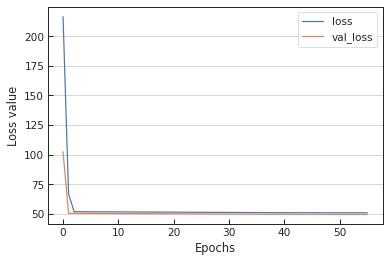

In [20]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid(axis='y')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.show()

In [21]:
# Encoding training data (with Monte Carlo sampling and averaging)
X_train_encoded = np.stack([encoder(X_train, training=True) for sample in range(100)]).mean(axis=0)
print(X_train_encoded.shape)
# Encoding testing data
X_test_encoded = np.stack([encoder(X_test, training=True) for sample in range(100)]).mean(axis=0)
print(X_test_encoded.shape)

(9600, 20)
(2400, 20)


In [22]:
# Computing weights for the class balancing of the DNN classifier
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))
print(class_weights_dict)

{0: 0.5215690535694882, 1: 12.090680100755668}


In [23]:
# Clone the encoder model
model_clone = keras.models.clone_model(encoder)
model_clone.set_weights(encoder.get_weights())
# Transfer learning from encoder to classifier
classifier_model = keras.models.Sequential(model_clone.layers[:-1])  # exclude last encoder layer
# Stack additional layers
classifier_model.add(keras.layers.Dense(128, activation='relu',
                                        kernel_initializer='glorot_normal',
                                        kernel_regularizer=keras.regularizers.l2(L2)))
classifier_model.add(keras.layers.Dropout(0.2))
classifier_model.add(keras.layers.Dense(64, activation='relu',
                                        kernel_initializer='glorot_normal',
                                        kernel_regularizer=keras.regularizers.l2(L2)))
classifier_model.add(keras.layers.Dropout(0.1))
classifier_model.add(keras.layers.Dense(1, activation='sigmoid'))
# Freezing layers (except newly added ones)
for layer in classifier_model.layers[:-5]:
    layer.trainable = False
EPOCHS = 200
BATCH_SIZE = 32
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=200, decay_rate=0.96, staircase=False)
adam_schedule = keras.optimizers.Adam(learning_rate=lr_schedule)
classifier_model.compile(optimizer=adam_schedule, loss='binary_crossentropy', metrics=['AUC'])
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, 
        patience=25, verbose=1, restore_best_weights=True)
# Train the classifier (first pass)
classification_history = classifier_model.fit(X_train_part, y_train_part, 
        epochs=EPOCHS, batch_size=BATCH_SIZE, 
        shuffle=True, validation_data=(X_validation, y_validation),
        class_weight=class_weights_dict, callbacks=[early_stopping], verbose=1)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/200
270/270 [==============================] - 2s 4ms/step - loss: 0.8049 - auc: 0.5004 - val_loss: 0.8237 - val_auc: 0.6151
Epoch 2/200
270/270 [==============================] - 1s 3ms/step - loss: 0.7629 - auc: 0.4932 - val_loss: 0.7072 - val_auc: 0.5946
Epoch 3/200
270/270 [==============================] - 1s 4ms/step - loss: 0.7486 - auc: 0.4841 - val_loss: 0.7577 - val_auc: 0.6323
Epoch 4/200
270/270 [==============================] - 1s 4ms/step - loss: 0.7379 - auc: 0.5251 - val_loss: 0.7167 - val_auc: 0.6523
Epoch 5/200
270/270 [==============================] - 1s 4ms/step - loss: 0.7324 - auc: 0.5237 - val_loss: 0.7860 - val_auc: 0.7090
Epoch 6/200
270/270 [==============================] - 1s 4ms/step - loss: 0.7277 - auc: 0.5267 - val_loss: 0.7218 - val_auc: 0.6800
Epoch 7/200
270/270 [==============================] - 1s 4ms/st

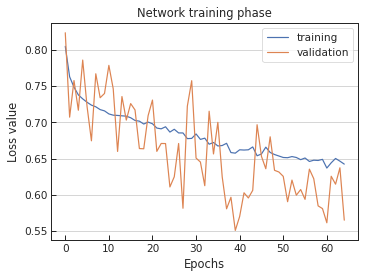

In [24]:
plt.figure(figsize=(5.5,4))
plt.title('Network training phase')
plt.plot(classification_history.history['loss'], label='training')
plt.plot(classification_history.history['val_loss'], label='validation')
plt.legend()
plt.grid(axis='y')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.show()

In [25]:
classifier_model.layers

In [26]:
# Un-freezing selected layers for fine-tuning
for layer in classifier_model.layers[3:-5]:
    print(layer)
    layer.trainable = True

In [27]:
# Fine-tuning network weights with a reduced learning rate (second pass)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-4,  # lower initial rate
        decay_steps=100, decay_rate=0.96, staircase=False)
adam = keras.optimizers.Adam(learning_rate=lr_schedule)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, 
        patience=50, verbose=1, restore_best_weights=True)
classifier_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['AUC'])
fine_tuning_history = classifier_model.fit(X_train_part, y_train_part, 
        epochs=EPOCHS, batch_size=BATCH_SIZE, 
        shuffle=False, validation_data=(X_validation, y_validation),
        class_weight=class_weights_dict, callbacks=[early_stopping], verbose=1)

Epoch 1/200
270/270 [==============================] - 2s 5ms/step - loss: 0.6442 - auc: 0.7276 - val_loss: 0.6311 - val_auc: 0.8514
Epoch 2/200
270/270 [==============================] - 1s 4ms/step - loss: 0.6040 - auc: 0.8013 - val_loss: 0.5727 - val_auc: 0.8885
Epoch 3/200
270/270 [==============================] - 1s 3ms/step - loss: 0.5829 - auc: 0.8210 - val_loss: 0.5817 - val_auc: 0.9024
Epoch 4/200
270/270 [==============================] - 1s 4ms/step - loss: 0.5580 - auc: 0.8504 - val_loss: 0.5702 - val_auc: 0.9088
Epoch 5/200
270/270 [==============================] - 1s 4ms/step - loss: 0.5354 - auc: 0.8659 - val_loss: 0.5660 - val_auc: 0.9125
Epoch 6/200
270/270 [==============================] - 1s 4ms/step - loss: 0.5288 - auc: 0.8640 - val_loss: 0.5718 - val_auc: 0.9152
Epoch 7/200
270/270 [==============================] - 1s 4ms/step - loss: 0.5106 - auc: 0.8768 - val_loss: 0.5385 - val_auc: 0.9170
Epoch 8/200
270/270 [==============================] - 1s 3ms/step - 

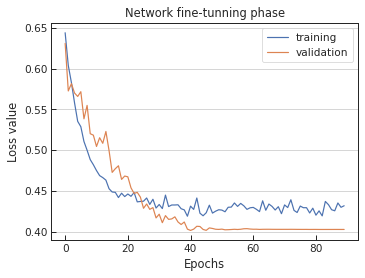

In [28]:
plt.figure(figsize=(5.5,4))
plt.title('Network fine-tunning phase')
plt.plot(fine_tuning_history.history['loss'], label='training')
plt.plot(fine_tuning_history.history['val_loss'], label='validation')
plt.legend()
plt.grid(axis='y')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.show()

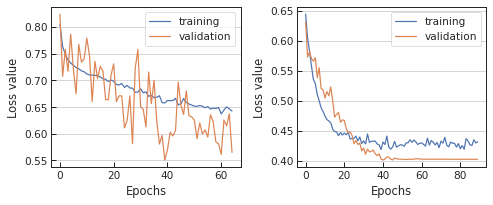

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))
#ax[0].set_title('Network training phase')
ax[0].plot(classification_history.history['loss'], label='training')
ax[0].plot(classification_history.history['val_loss'], label='validation')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss value')
ax[0].legend(loc='upper right')
ax[0].grid(axis='y')
#ax[1].set_title('Network fine-tuning phase')
ax[1].plot(fine_tuning_history.history['loss'], label='training')
ax[1].plot(fine_tuning_history.history['val_loss'], label='validation')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss value')
ax[1].legend(loc='upper right')
ax[1].grid(axis='y')
fig.tight_layout()
plt.show()


In [30]:
y_scores = classifier_model.predict(X_test).flatten()

In [31]:
y_scores.shape

(2400,)

In [32]:
# Precision/recall trade-off 
precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_scores)
# Find a best threshold value (where precision and recall curves intersect)
EPSILON = 1e-3  # Tolerance
THRESHOLD = thresholds[np.argwhere(abs(precisions - recalls) < EPSILON)][0][0]
print(THRESHOLD)

0.8078263


In [33]:
def precision_recall_tradeoff(thresholds, precisions, recalls, threshold, title=''):
    fig, ax = plt.subplots(figsize=(5.5,3.5))
    ax.set_title(title)
    ax.plot(thresholds, precisions[:-1], lw=2, label='Precision')
    ax.plot(thresholds, recalls[:-1], lw=2, label='Recall')
    plt.vlines(threshold, 0, 1, linestyles='--', color='dimgrey', 
               label='Threshold = {:.2f}'.format(threshold))
    ax.set_xlabel('Thresholds')
    ax.set_ylabel('Precision / Recall')
    ax.legend(loc='center left')
    ax.grid()
    fig.tight_layout()
    plt.show()
    return

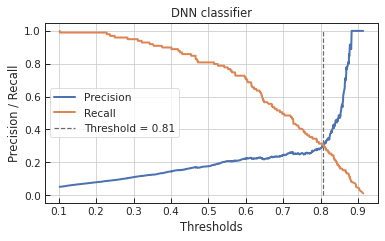

In [34]:
# Show precision/recall curves
precision_recall_tradeoff(thresholds, precisions, recalls, THRESHOLD, title='DNN classifier')

In [35]:
pred = np.where(y_scores >= THRESHOLD, 1, 0)

In [36]:
 #Monte Carlo predictions
predictions = np.stack([classifier_model(X_test, training=True) for sample in range(100)])
predictions = predictions.reshape(100, -1)
predictions.shape

(100, 2400)

In [37]:
# Showing boxplots for select cases
predicts = pd.DataFrame(predictions[:,[11,12,13,16,19]], 
                        columns=['Case {:d}'.format(i+1) for i in range(5)])

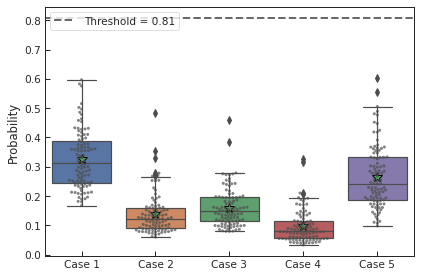

In [38]:
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(data=predicts, orient='v', ax=ax, showmeans=True, 
            meanprops={'marker': '*', 'markeredgecolor': 'black', 'markersize': '10'})
sns.swarmplot(data=predicts, orient='v', size=3, color='.3', alpha=0.7, ax=ax)
ax.axhline(THRESHOLD, ls='--', lw=2, color='dimgrey', label='Threshold = {:.2f}'.format(THRESHOLD))
ax.legend(loc='upper left')
ax.set_ylabel('Probability')
fig.tight_layout()
plt.show()

In [39]:
def show_confusion_matrix(y_true, y_pred, labels, title):
    scores_image = heatmap(metrics.confusion_matrix(y_true, y_pred), xlabel='Predicted label', 
                       ylabel='True label', xticklabels=labels, yticklabels=labels, 
                       cmap=plt.cm.gray_r, fmt="%d")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()
    return

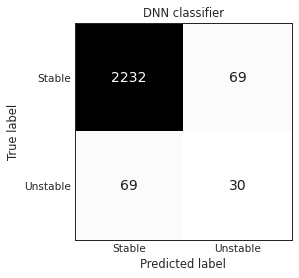

In [40]:
labels = ['Stable', 'Unstable']
# confusion matrix
show_confusion_matrix(y_test, pred, labels, title='DNN classifier')

In [41]:
# classification report
print(metrics.classification_report(y_test, pred, target_names=labels))

              precision    recall  f1-score   support

      Stable       0.97      0.97      0.97      2301
    Unstable       0.30      0.30      0.30        99

    accuracy                           0.94      2400
   macro avg       0.64      0.64      0.64      2400
weighted avg       0.94      0.94      0.94      2400



In [42]:
dnn_data = pd.DataFrame(data=[metrics.accuracy_score(y_test, pred), 
                              metrics.recall_score(y_test, pred),
                              metrics.precision_score(y_test, pred), 
                              metrics.roc_auc_score(y_test, pred),
                              metrics.f1_score(y_test, pred), 
                              matthews_score(y_test, pred), 
                              brier_score(y_test, y_scores)],
                        index=["accuracy", "recall", "precision", "roc_auc_score", 
                               "f1-score", "matthews", "brier"], 
                        columns=['Values'])